## Filter Dataset

In [1]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from collections import Counter
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features, load_dataset
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import random
import torch

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
topic = "cannabis" #"energie" #"kinder" "cannabis"

In [4]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed")
print(dataset)
print(dataset[1])

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label'],
    num_rows: 59363
})
{'_id': '648c2ad88e8cadbd29004e48', 'batch_id': 15, 'domain': 'amazon.de', 'view_url': 'www.amazon.de/gp/buy/addressselect/handlers/display.html?_from=cheetah', 'lang': 'de', 'text': ' Weiter ohne zu akzeptieren Wählen Sie Ihre Cookie-Einstellungen Wir verwenden Cookies und ähnliche Tools, die erforderlich sind, um Ihnen Einkäufe zu ermöglichen, Ihr Einkaufserlebnis zu verbessern und unsere Dienste bereitzustellen. Dies wird auch in unseren Cookie-Bestimmungen beschrieben. Wir verwenden diese Cookies auch, um nachzuvollziehen, wie Kunden unsere Dienste nutzen (z. B. durch Messung der Websiteaufrufe), damit wir Verbesserungen vornehmen können. Wenn Sie damit einverstanden sind, verwenden wir auch Cookies, um Ihr Einkaufserlebnis in den Stores zu erg

## Filter by Content Length

In [5]:
tokenizer = AutoTokenizer.from_pretrained("deepset/gbert-large")

In [6]:
def get_input_length(text):
    """ Tokenize the input text and return the number of tokens """
    return len(tokenizer.encode(text, add_special_tokens=True, truncation=False, padding=False))

print(get_input_length("Hello, my name is John Doe"))

12


In [7]:
def update_metrics(example):
    example['text_length'] = len(example['text'])
    example['word_count'] = len(example['text'].split())
    example['token_count'] = get_input_length(example['text'])
    return example

dataset = dataset.map(update_metrics)

In [8]:
token_counts = dataset["token_count"]

In [9]:
max_token_count = max(token_counts)
min_token_count = min(token_counts)
avg_token_count = sum(token_counts) / len(token_counts)
std_token_count = np.std(token_counts)  # Using numpy for standard deviation

print(f"Maximum token count: {max_token_count}")
print(f"Minimum token count: {min_token_count}")
print(f"Average token count: {avg_token_count}")
print(f"Standard deviation of token count: {std_token_count}")

Maximum token count: 2802142
Minimum token count: 2
Average token count: 1518.2947290399743
Standard deviation of token count: 13173.22272503524


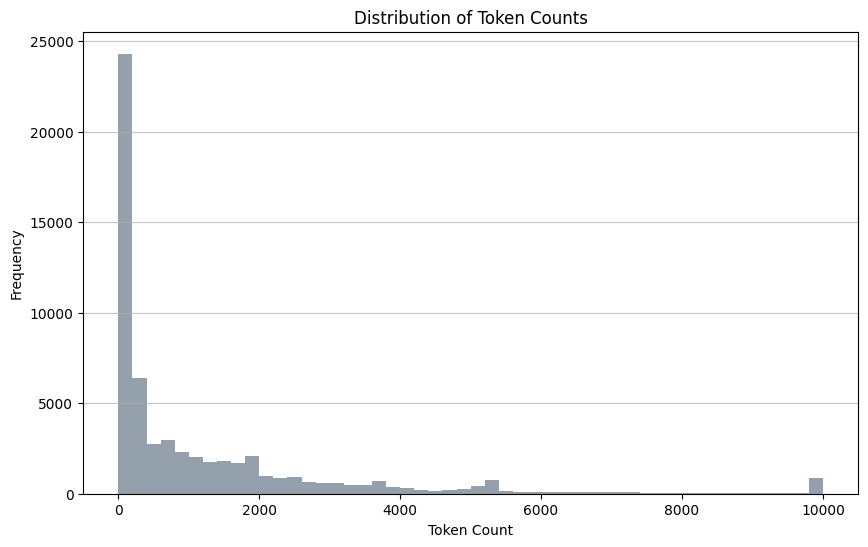

In [10]:
import matplotlib.pyplot as plt

# Plotting the distribution of token counts with a more muted color
plt.figure(figsize=(10, 6))
plt.hist([min(count, 10000) for count in token_counts], bins=50, alpha=0.75, color='slategray')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

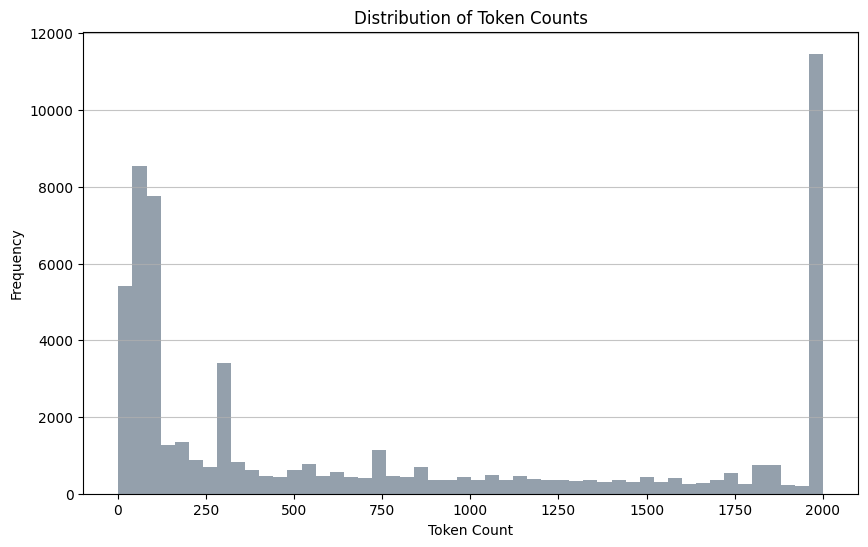

In [11]:
import matplotlib.pyplot as plt

# Plotting the distribution of token counts with a more muted color
plt.figure(figsize=(10, 6))
plt.hist([min(count, 2000) for count in token_counts], bins=50, alpha=0.75, color='slategray')
plt.title('Distribution of Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [12]:
import random
from pprint import pprint

def sample_and_print(dataset, n, m, sample_size=10):
    """
    Samples and pretty-prints examples from the dataset where the token count is between n and m.

    Parameters:
    - dataset: The dataset to sample from.
    - n: The lower bound of the token count range.
    - m: The upper bound of the token count range.
    - sample_size: The number of examples to sample and print. Default is 10.
    """
    
    # Ensure there's a 'token_count' column
    if 'token_count' not in dataset.column_names:
        raise ValueError("Dataset must contain a 'token_count' column.")
    
    # Filter the dataset for examples with token_count between n and m
    filtered_examples = [example for example in dataset if n <= example['token_count'] <= m]

    # Check if there are enough examples to sample
    if len(filtered_examples) < sample_size:
        print(f"Only {len(filtered_examples)} examples found with token count between {n} and {m}.")
        sample_size = len(filtered_examples)

    # Randomly sample examples from the filtered list
    sampled_examples = random.sample(filtered_examples, sample_size)

    # Pretty print the sampled examples
    for example in sampled_examples:
        pprint(example)
        print("-" * 80)  # Separator for readability


In [13]:
# n = 0  # Define the lower bound for token count
# m = 5  # Define the upper bound for token count

# # Call the function
# sample_and_print(dataset, n, m)

In [14]:
# Define your conditions
n = 6000  # Upper limit
m = 0   # Lower limit, assuming you actually meant m is less than n

# Filter the dataset
dataset = dataset.filter(lambda example: example['token_count'] > m and example['token_count'] < n)

## Filter by Language

In [15]:
lang_counts = Counter(dataset['lang'])
print("Lang frequencies:", lang_counts)

Lang frequencies: Counter({'de': 38654, 'en': 17432, 'ru': 196, 'nl': 180, 'tl': 156, 'et': 110, 'it': 97, 'fr': 93, 'sv': 77, 'es': 65, 'pt': 65, 'ja': 52, 'cs': 48, 'ca': 39, 'ko': 30, 'da': 24, 'no': 19, 'cy': 18, 'af': 10, 'sl': 8, 'id': 4, 'so': 3, 'pl': 3, 'ro': 3, 'sk': 3, 'hu': 2, 'vi': 2, 'uk': 2, 'fi': 1, 'lv': 1, 'el': 1, 'sw': 1, 'bg': 1, 'tr': 1, 'zh-cn': 1, 'ar': 1})


In [16]:
#dataset = dataset.filter(lambda example: example['lang'] == "de")

## Filter by Category

In [17]:
print("Number of examples before filtering:", len(dataset))
dataset_filtered = dataset.filter(lambda example: example['good_for_training'] == "True")
dataset_extended = dataset.filter(lambda example: example['good_for_training'] == "False")
print("Number of examples after filtering:", len(dataset))

Number of examples before filtering: 57403
Number of examples after filtering: 57403


## Save Dataset

In [18]:
dataset_filtered

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
    num_rows: 4150
})

In [19]:
dataset_filtered.remove_columns(["token_count"])
dataset_filtered.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_filtered")

Saving the dataset (0/1 shards):   0%|          | 0/4150 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 4150/4150 [00:00<00:00, 22768.74 examples/s]


In [20]:
dataset_extended

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count'],
    num_rows: 53253
})

In [21]:
dataset_extended.remove_columns(["token_count"])
dataset_extended.save_to_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_extended_filtered")

Saving the dataset (1/1 shards): 100%|██████████| 53253/53253 [00:01<00:00, 34132.51 examples/s]
